<a href="https://colab.research.google.com/github/Dargel/AI_Rating_NER_comparison/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_1_3_%D0%94%D0%B0%D1%80%D0%B3%D0%B5%D0%BB%D1%8C_%D0%AE__NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install nltk
!pip install pymorphy3
#!pip install regex
#!pip install wordcloud

import os
import re
import pandas as pd

import nltk
from nltk import download
download('punkt_tab')
download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

import pymorphy3
from pymorphy3 import MorphAnalyzer

from collections import Counter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 40.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df = pd.read_csv('AI_Comnews.csv') #загружаем ранее собранный корпус статей
df

,date,title,text,link
0,25.12.2024,На Открытой конференции ИСП РАН 2024 обсудили ...,1500 участников собрала Открытая конференция И...,https://www.comnews.ru/content/237018/1018/
1,24.12.2024,"BIA Technologies: автоматизация, цифровые двой...","Развитие цифровых решений для логистики, торго...",https://www.comnews.ru/content/237017/1018/
2,24.12.2024,Киберэксперт Дмитрий Овчинников назвал топ-3 с...,В новогодние праздники мошенники традиционно а...,https://www.comnews.ru/content/237016/1018/
3,24.12.2024,Письмо Деду Морозу от редакции ComNews,Дорогой Дедушка Мороз! Пишет тебе редакция Com...,https://www.comnews.ru/content/236941/2024-12-...
4,23.12.2024,Экзоскелеты с искусственным интеллектом разраб...,"Компании ООО ""Экзо Солюшенс"" и ""Социальный код...",https://www.comnews.ru/digital-economy/content...
...,...,...,...,...
1468,19.01.2022,"Единый контакт-центр аптечной сети ""Ригла"" объ...",NAUMEN завершил работы по созданию единого кон...,https://www.comnews.ru/content/218353
1469,14.01.2022,Совершенствование систем удаленной работы прод...,"Как отмечают в Lenovo, удаленный режим работы ...",https://www.comnews.ru/content/218259/2022-01-...
1470,13.01.2022,Рынок СХД в тисках жизненного цикла,"Такие данные приводят ""Т1 Интеграция"", Huawei ...",https://www.comnews.ru/content/218243
1471,12.01.2022,"ИИ предсказал, где новые лекарства смогут подо...",Научная группа iMolecule из Сколтеха разработа...,https://www.comnews.ru/digital-economy/content...


Начинаем поиск именованных сущностей

In [5]:
#устанавливаем SpaCy
! pip install spacy
! python -m spacy download ru_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 67.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
#импортируем NER
import spacy as spacy
from spacy import load
from spacy.lang.ru.examples import sentences
from spacy.lang.ru import Russian
load_model = spacy.load('ru_core_news_sm')

In [7]:
#Функция для поиска именованных сущностей в столбце датасета, которые повторяются не менее 3 раз + лемматизация
def co_names_sp(text):
  co_names = []
  org = []
  doc = load_model(text)
  stop_words = stopwords.words('russian')
  morph = MorphAnalyzer()
  for entity in doc.ents:
    if entity.label_ == 'ORG': #находим названия организаций
      try:
        org_nltk = word_tokenize(entity.text) #токенизируем кириллические названия
        org_clean = [word for word in org_nltk if word not in stop_words and word[0].isalpha()] #удаляем стоп-слова и "мусор"
        for word in org_clean:
          lemm = morph.parse(word)[0].normal_form #лемматизируем кириллические названия
          co_names.append(lemm)
      except:
        co_names.append(entity.text) #подхватываем англоязычные названия
  org_frequencies = FreqDist(co_names) #считаем частоту в статье
  for token, frequency in org_frequencies.items():
    if frequency >= 3: #если частота больше 3, предполагаем, что слово может нам подойти
      org.append(token)
  return org

In [8]:
df['org_names'] = df['text'].apply(co_names_sp) #создаем новый столбец с названиями. Занимает около 12 мин
df

,date,title,text,link,org_names
0,25.12.2024,На Открытой конференции ИСП РАН 2024 обсудили ...,1500 участников собрала Открытая конференция И...,https://www.comnews.ru/content/237018/1018/,"[исп, ран, центр, криптография, академия, инст..."
1,24.12.2024,"BIA Technologies: автоматизация, цифровые двой...","Развитие цифровых решений для логистики, торго...",https://www.comnews.ru/content/237017/1018/,"[bia, technologies]"
2,24.12.2024,Киберэксперт Дмитрий Овчинников назвал топ-3 с...,В новогодние праздники мошенники традиционно а...,https://www.comnews.ru/content/237016/1018/,[]
3,24.12.2024,Письмо Деду Морозу от редакции ComNews,Дорогой Дедушка Мороз! Пишет тебе редакция Com...,https://www.comnews.ru/content/236941/2024-12-...,[]
4,23.12.2024,Экзоскелеты с искусственным интеллектом разраб...,"Компании ООО ""Экзо Солюшенс"" и ""Социальный код...",https://www.comnews.ru/digital-economy/content...,[]
...,...,...,...,...,...
1468,19.01.2022,"Единый контакт-центр аптечной сети ""Ригла"" объ...",NAUMEN завершил работы по созданию единого кон...,https://www.comnews.ru/content/218353,"[naumen, ригла]"
1469,14.01.2022,Совершенствование систем удаленной работы прод...,"Как отмечают в Lenovo, удаленный режим работы ...",https://www.comnews.ru/content/218259/2022-01-...,"[lenovo, iva, вкс, trueconf, црт]"
1470,13.01.2022,Рынок СХД в тисках жизненного цикла,"Такие данные приводят ""Т1 Интеграция"", Huawei ...",https://www.comnews.ru/content/218243,"[huawei, схд, ispsystem, enterprise, rdma, yadro]"
1471,12.01.2022,"ИИ предсказал, где новые лекарства смогут подо...",Научная группа iMolecule из Сколтеха разработа...,https://www.comnews.ru/digital-economy/content...,[сколтех]


In [10]:
#Как и в авторском варианте, в первоначальном списке много мусора. Поэтому чистим вручную
exclude = ['ооо', 'центр', 'цифровой', 'пао', 'ано', 'университет', 'comnews', 'гк', 'ао', 'россия', 'engines', 'group', 'лаборатория', 'ассоциация', 'ит', 'ai', 'технология', 'группа', 'фонд', 'экономика', 'компания', 'cloud', 'развитие', 'банк', 'возможность', 'technologies', 'известие', 'страна', 'институт', 'система', 'российский', 'нефть', 'microsoft', 'google', 'правительство', 'государственный', 'апк', 'раэк', 'llm', 'управление', 'data', 'ия', 'chatgpt', 'ит-компания', 'госдума', 'минэкономразвития', 'альянс', 'платформа', 'информационный', 'департамент', 'московский', 'национальный', 'инновация', 'цод', 'министерство', 'hr', 'гис', 'telecom', 'оао', 'digital', 'финтех', 'ниу', 'роскомнадзор', 'искусственный', 'интеллект', 'итмый', 'vision', 'холдинг', 'комбинат', 'связь', 'оператор', 'школа', 'госкорпорация', 'rpa', 'безопасность', 'решение', 'forbes', 'новый', 'здравоохранение', 'sap', 'big', 'интернет', 'devops', 'совет', 'lab', 'openai', 'абд', 'вкс', ]
print(len(exclude)) #исключений на 20% меньше, чем в авторском варианте

88


In [11]:
#собираем список компаний, которым посвящены публикации
brands = []
for group in df['org_names']:
  for word in group:
    if word not in exclude:
      brands.append(word)
print(brands)


['исп', 'ран', 'криптография', 'академия', 'исследование', 'системный', 'bia', 'магнит', 'remez', 'м.видео-эльдорадо', 'первый', 'битый', 'ideco', 'skydns', 'биорг', 'тнг-группа', 'фас', 'билайн', 'мтс', 'security', 'youtube', 'rutube', 'сми', 'corp', 'точка', 'ципр', 'neiry', 'exodrive', 'visionlabs', 'q-systems', 'cloud.ru', 'evolution', 'нг', 'нти', 'iks-consulting', 'cloud.ru', 'убрир', 'биорг', 'гбу', 'ло', 'мфц', 'яндекс', 'академия', 'исп', 'ран', 'криптография', 'т-технология', 't-lite', 'ru', 'arena', 'hard', 'mt', 'bench', 'alpacaeval', 't-pro', 'русало', 'membrana', 'kids', 'мтс', 'future', 'crew', 'авантелек', 'центральный', 'airi', 'математический', 'x-com', 'sberdevices', 'транстелек', 'транспортный', 'федеральный', 'русагро', 'vk', 'tech', 'мойофис', 'белгородский', 'санкт-петербургский', 'gorodpay', 'газпромбанк', 'sl', 'soft', 'robin', 'русало', 'газпром', 'информ', 'ред', 'софт', 'илим', 'мосэнергосбыт', 'сигма', 'salutejazz', 'сбер', 'мтс', 'цифра', 'дисилоджик', 'ци

In [12]:
#наводим порядок с разным написанием одних и тех же компаний
brands_clean = []
for word in brands:
  if "сбер" in word:
    word = 'сбер'
  if "sber" in word:
    word = 'сбер'
  if "mts" in word:
    word = 'мтс'
  if "yandex" in word:
    word = 'яндекс'
  if "мегафон" in word:
    word = 'мегафон'
  if "smart" in word:
    word = 'Smart Engines'
  if "русал" in word:
    word = 'русал'
  if "авить" in word:
    word = 'авито'
  if "iva" in word:
    word = 'Iva Technologies'
  if "beorg" in word:
    word = 'биорг'
  if "вымпелком" in word:
      word = 'билайн'
  if "нти" in word:
    word = 'Фонд НТИ'
  if "positive" in word:
    word = 'Positive Technologies'
  if "vk" in word:
    word = 'ВКонтакте'
  if "х5" in word:
    word = 'X5'
  if "гпб" in word:
    word = 'газпромбанк'
  if "тиньк" in word or "т-банк" in word:
    word = 'Т-Банк'
  if "гринат" in word:
    word = 'Гринатом'
  if "ростёх" in word or "ростех" in word:
    word = 'Ростех'
  if "сеченовский" in word or "ростех" in word:
    word = 'Сеченовский Университет'
  word = word[0].upper() + word[1:] #заодно вернем им первую заглавную букву
  if len(word)<=3: #а названия из 3 букв сделаем полностью капсом
    word = word.upper()
  brands_clean.append(word)
print(brands_clean)

['ИСП', 'РАН', 'Криптография', 'Академия', 'Исследование', 'Системный', 'BIA', 'Магнит', 'Remez', 'М.видео-эльдорадо', 'Первый', 'Битый', 'Ideco', 'Skydns', 'Биорг', 'Тнг-группа', 'ФАС', 'Билайн', 'МТС', 'Security', 'Youtube', 'Rutube', 'СМИ', 'Corp', 'Точка', 'Ципр', 'Neiry', 'Exodrive', 'Visionlabs', 'Q-systems', 'Cloud.ru', 'Evolution', 'НГ', 'Фонд НТИ', 'Iks-consulting', 'Cloud.ru', 'Убрир', 'Биорг', 'ГБУ', 'ЛО', 'МФЦ', 'Яндекс', 'Академия', 'ИСП', 'РАН', 'Криптография', 'Т-технология', 'T-lite', 'RU', 'Arena', 'Hard', 'MT', 'Bench', 'Alpacaeval', 'T-pro', 'Русал', 'Membrana', 'Kids', 'МТС', 'Future', 'Crew', 'Авантелек', 'Центральный', 'Airi', 'Математический', 'X-com', 'Сбер', 'Транстелек', 'Транспортный', 'Федеральный', 'Русагро', 'ВКонтакте', 'Tech', 'Мойофис', 'Белгородский', 'Санкт-петербургский', 'Gorodpay', 'Газпромбанк', 'SL', 'Soft', 'Robin', 'Русал', 'Газпром', 'Информ', 'РЕД', 'Софт', 'Илим', 'Мосэнергосбыт', 'Сигма', 'Salutejazz', 'Сбер', 'МТС', 'Цифра', 'Дисилоджик', 

In [13]:
#Формируем рейтинг

AI_rating_spacy = FreqDist(brands_clean)
AI_rating_spacy.most_common(55)

#55 компаний имеют публикаций и больше. Для сравнения: в авторском варианте - 57
#оставшиеся позиции непоказательны, поэтому не вычищались

[('МТС', 53),
 ('Сбер', 52),
 ('Яндекс', 37),
 ('Smart Engines', 28),
 ('Сколково', 25),
 ('Ростелеком', 25),
 ('BSS', 22),
 ('Биорг', 21),
 ('Газпром', 18),
 ('ВТБ', 15),
 ('Росатом', 15),
 ('ВКонтакте', 13),
 ('ЦРТ', 13),
 ('Цифра', 12),
 ('Сибур', 12),
 ('Visionlabs', 11),
 ('Билайн', 9),
 ('Газпромбанк', 9),
 ('Iva Technologies', 9),
 ('Т-Банк', 9),
 ('Ntechlab', 9),
 ('Мегафон', 9),
 ('Рдтех', 9),
 ('РАН', 8),
 ('Академия', 8),
 ('Магнит', 8),
 ('Русал', 8),
 ('Telegram', 8),
 ('РЖД', 8),
 ('Рексофт', 8),
 ('Газинформсервис', 8),
 ('ВШЭ', 8),
 ('Фонд НТИ', 7),
 ('Сеченовский Университет', 7),
 ('Нлмк', 7),
 ('Россельхозбанк', 7),
 ('Норникель', 7),
 ('Почта', 7),
 ('Cloud.ru', 6),
 ('Русагро', 6),
 ('Мойофис', 6),
 ('Гринатом', 6),
 ('Роснефть', 6),
 ('MCN', 6),
 ('Nexign', 6),
 ('Positive Technologies', 6),
 ('Альфа-банк', 6),
 ('X5', 6),
 ('Airi', 5),
 ('Naumen', 5),
 ('МГУ', 5),
 ('Ростех', 5),
 ('Дом.рф', 5),
 ('ПСБ', 5),
 ('Softlogic', 5)]

<Axes: title={'center': 'ТОП ИИ-брендов от SpaCy'}, xlabel='Samples', ylabel='Counts'>

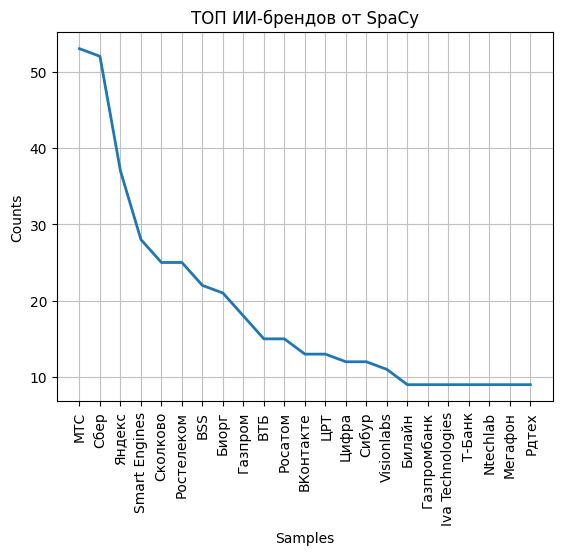

In [14]:
AI_rating_spacy.plot(23, title='ТОП ИИ-брендов от SpaCy')#те, у кого 9+ публикаций

In [ ]:
#Создаем словарь из компаний и кол-ва публикаций для построения облака
comp = []
freq = []
for token, frequency in AI_rating_spacy.items():
  if frequency >= 9: #визуализируем те, у кого от 9 публикаций (23 компани, для сравнения в авторском варианте - 22)
    comp.append(token)
    freq.append(frequency)
top_spacy = dict(zip(comp, freq))
print(top_spacy)

{'Биорг': 21, 'Билайн': 9, 'МТС': 53, 'Visionlabs': 11, 'Яндекс': 37, 'Сбер': 52, 'ВКонтакте': 13, 'Газпромбанк': 9, 'Газпром': 18, 'Цифра': 12, 'Iva Technologies': 9, 'Т-Банк': 9, 'Сколково': 25, 'Ntechlab': 9, 'ВТБ': 15, 'Ростелеком': 25, 'Мегафон': 9, 'Росатом': 15, 'Сибур': 12, 'Smart Engines': 28, 'BSS': 22, 'Рдтех': 9, 'ЦРТ': 13}


In [ ]:
#утанавливаем библиотеку для создания облака слов
from wordcloud import WordCloud
import matplotlib.pyplot as plt

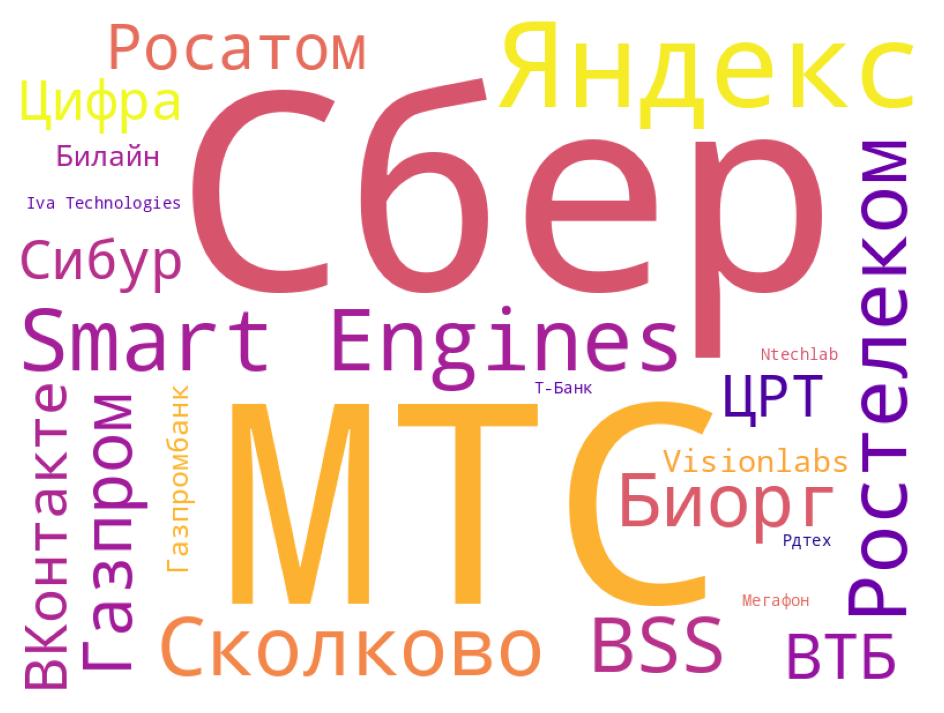

In [ ]:
#создаем облако
wordcloud = WordCloud(margin = 15,
                      width = 800,
                      height = 600,
                      background_color='white',
                      colormap='plasma').generate_from_frequencies(top_spacy)
plt.figure(figsize=(12, 9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#сохраняем картинку
wordcloud.to_file('AI_TOP_spacy.png')